# Feature Engineering with pySpark

### Index 

1. Feature generation
2. Time Features
3. Extracting Text to New Features
4. Binarizing, Bucketing & Encoding


In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler

import pyspark.ml.evaluation as evals
import pyspark.ml.tuning as tune
from pyspark.ml.classification import LogisticRegression

sc = SparkContext(master = "local", appName = "ML Pipelines") 
spark = SparkSession(sc)
sqlContext = SQLContext(spark)

In [2]:
import pandas as pd
url = 'https://assets.datacamp.com/production/repositories/1704/datasets/d26c25f46746882d0a0f474cc6709c629f69872c/2017_StPaul_MN_Real_Estate.csv'
df = pd.read_csv(url)
df.columns = map(str.upper, df.columns) # we want all column names in capital letters
df.head()

,NO.,MLSID,STREETNUMBERNUMERIC,STREETADDRESS,STREETNAME,POSTALCODE,STATEORPROVINCE,CITY,SALESCLOSEPRICE,LISTDATE,...,ROOMAREA7,ROOMFLOOR7,ROOMAREA8,ROOMFLOOR8,BEDROOMS,SQFTBELOWGROUND,ASSUMABLEMORTGAGE,ASSOCIATIONFEE,ASSESSMENTPENDING,ASSESSEDVALUATION
0,1,RMLS,11511,11511 Stillwater Blvd N,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,...,NaN,NaN,NaN,NaN,3,0,NaN,0,Unknown,0.0
1,2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,...,10x11,Main,11x11,Lower,4,960,NaN,0,Unknown,0.0
2,3,RMLS,8583,8583 Stillwater Blvd N,Stillwater,55042,MN,LELM - Lake Elmo,225000,6/26/2017 0:00,...,NaN,NaN,NaN,NaN,2,0,Not Assumable,0,No,0.0
3,4,RMLS,9350,9350 31st St N,31st,55042,MN,LELM - Lake Elmo,265000,8/25/2017 0:00,...,NaN,NaN,NaN,NaN,2,348,NaN,0,Unknown,0.0
4,5,RMLS,2915,2915 Inwood Ave N,Inwood,55042,MN,LELM - Lake Elmo,249900,9/12/2017 0:00,...,14x13,Lower,NaN,NaN,3,1026,NaN,0,No,0.0


In [3]:
print(df.columns)

Index(['NO.', 'MLSID', 'STREETNUMBERNUMERIC', 'STREETADDRESS', 'STREETNAME',
       'POSTALCODE', 'STATEORPROVINCE', 'CITY', 'SALESCLOSEPRICE', 'LISTDATE',
       'LISTPRICE', 'LISTTYPE', 'ORIGINALLISTPRICE', 'PRICEPERTSFT',
       'FOUNDATIONSIZE', 'FENCE', 'MAPLETTER', 'LOTSIZEDIMENSIONS',
       'SCHOOLDISTRICTNUMBER', 'DAYSONMARKET', 'OFFMARKETDATE', 'FIREPLACES',
       'ROOMAREA4', 'ROOMTYPE', 'ROOF', 'ROOMFLOOR4', 'POTENTIALSHORTSALE',
       'POOLDESCRIPTION', 'PDOM', 'GARAGEDESCRIPTION', 'SQFTABOVEGROUND',
       'TAXES', 'ROOMFLOOR1', 'ROOMAREA1', 'TAXWITHASSESSMENTS', 'TAXYEAR',
       'LIVINGAREA', 'UNITNUMBER', 'YEARBUILT', 'ZONING', 'STYLE', 'ACRES',
       'COOLINGDESCRIPTION', 'APPLIANCES', 'BACKONMARKETDATE',
       'ROOMFAMILYCHAR', 'ROOMAREA3', 'EXTERIOR', 'ROOMFLOOR3', 'ROOMFLOOR2',
       'ROOMAREA2', 'DININGROOMDESCRIPTION', 'BASEMENT', 'BATHSFULL',
       'BATHSHALF', 'BATHQUARTER', 'BATHSTHREEQUARTER', 'CLASS', 'BATHSTOTAL',
       'BATHDESC', 'ROOMAREA5', 'ROOM

In [4]:
# Create a Spark DataFrame from the pandas data frame 
dfSchema = StructType([
    StructField('NO.', LongType(), False),
    StructField('MLSID', StringType(), False),
    StructField('STREETNUMBERNUMERIC', LongType(), False),
    StructField('STREETADDRESS', StringType(), False),
    StructField('STREETNAME', StringType(), False),
    StructField('POSTALCODE', LongType(), False),
    StructField('STATEORPROVINCE', StringType(), False),
    StructField('CITY', StringType(), False),
    StructField('SALESCLOSEPRICE', LongType(), False),
    StructField('LISTDATE', StringType(), False),
    StructField('LISTPRICE', LongType(), False),
    StructField('LISTTYPE', StringType(), False),
    StructField('ORIGINALLISTPRICE', LongType(), False), 
    StructField('PRICEPERTSFT', FloatType(), False),
    StructField('FOUNDATIONSIZE',  LongType(), False),
    StructField('FENCE', StringType(), False),
    StructField('MAPLETTER', StringType(), False),
    StructField('LOTSIZEDIMENSIONS', StringType(), False),
    StructField('SCHOOLDISTRICTNUMBER', StringType(), False),
    StructField('DAYSONMARKET', LongType(), False),
    StructField('OFFMARKETDATE', StringType(), False), 
    StructField('FIREPLACES', LongType(), False),
    StructField('ROOMAREA4', StringType(), False), 
    StructField('ROOMTYPE', StringType(), False), 
    StructField('ROOF', StringType(), False), 
    StructField('ROOMFLOOR4', StringType(), False), 
    StructField('POTENTIALSHORTSALE', StringType(), False), 
    StructField('POOLDESCRIPTION', StringType(), False), 
    StructField('PDOM', IntegerType(), False),
    StructField('GARAGEDESCRIPTION', StringType(), False), 
    StructField('SQFTABOVEGROUND', LongType(), False),
    StructField('TAXES', LongType(), False),
    StructField('ROOMFLOOR1', StringType(), False), 
    StructField('ROOMAREA1', StringType(), False), 
    StructField('TAXWITHASSESSMENTS', FloatType(), False),
    StructField('TAXYEAR', LongType(), False),
    StructField('LIVINGAREA', LongType(), False), 
    StructField('UNITNUMBER', StringType(), False),  
    StructField('YEARBUILT', LongType(), False),
    StructField('ZONING', StringType(), False), 
    StructField('STYLE', StringType(), False), 
    StructField('ACRES', FloatType(), False),
    StructField('COOLINGDESCRIPTION', StringType(), False), 
    StructField('APPLIANCES', StringType(), False), 
    StructField('BACKONMARKETDATE', FloatType(), False),
    StructField('ROOMFAMILYCHAR', StringType(), False), 
    StructField('ROOMAREA3', StringType(), False), 
    StructField('EXTERIOR', StringType(), False), 
    StructField('ROOMFLOOR3', StringType(), False), 
    StructField('ROOMFLOOR2', StringType(), False), 
    StructField('ROOMAREA2', StringType(), False), 
    StructField('DININGROOMDESCRIPTION', StringType(), False), 
    StructField('BASEMENT', StringType(), False), 
    StructField('BATHSFULL', LongType(), False),
    StructField('BATHSHALF', LongType(), False),
    StructField('BATHQUARTER', LongType(), False),
    StructField('BATHSTHREEQUARTER', FloatType(), False),
    StructField('CLASS', StringType(), False), 
    StructField('BATHSTOTAL', LongType(), False),
    StructField('BATHDESC', StringType(), False), 
    StructField('ROOMAREA5', StringType(), False), 
    StructField('ROOMFLOOR5', StringType(), False), 
    StructField('ROOMAREA6', StringType(), False), 
    StructField('ROOMFLOOR6', StringType(), False), 
    StructField('ROOMAREA7', StringType(), False), 
    StructField('ROOMFLOOR7', StringType(), False), 
    StructField('ROOMAREA8', StringType(), False), 
    StructField('ROOMFLOOR8', StringType(), False), 
    StructField('BEDROOMS', LongType(), False),
    StructField('SQFTBELOWGROUND', LongType(), False), 
    StructField('ASSUMABLEMORTGAGE', StringType(), False), 
    StructField('ASSOCIATIONFEE', LongType(), False),
    StructField('ASSESSMENTPENDING', StringType(), False), 
    StructField('ASSESSEDVALUATION', FloatType(), False)
])

real_estate_df = spark.createDataFrame(df, dfSchema)

# 1. Feature generation
## 1.1 Differences
Let's explore generating features using existing ones. In the midwest of the U.S. many single family homes have extra land around them for green space. In this example you will create a new feature called `'YARD_SIZE'`, and then see if the new feature is correlated with our outcome variable.

In [5]:
# Lot size in square feet
acres_to_sqfeet = 43560 # conversion factor
df = real_estate_df.withColumn('LOT_SIZE_SQFT', col('ACRES') * acres_to_sqfeet)

# Create new column YARD_SIZE by subtracting FOUNDATIONSIZE from LOT_SIZE_SQFT
df = df.withColumn('YARD_SIZE', col('LOT_SIZE_SQFT') - col('FOUNDATIONSIZE'))

In [6]:
# Corr of ACRES vs SALESCLOSEPRICE
print("Corr of ACRES vs SALESCLOSEPRICE: " + str(df.corr('LOT_SIZE_SQFT', 'SALESCLOSEPRICE')))
# Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE
print("Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: " + str(df.corr('FOUNDATIONSIZE', 'SALESCLOSEPRICE')))
# Corr of YARD_SIZE vs SALESCLOSEPRICE
print("Corr of YARD_SIZE vs SALESCLOSEPRICE: " + str(df.corr('YARD_SIZE', 'SALESCLOSEPRICE')))

Corr of ACRES vs SALESCLOSEPRICE: 0.22060612287915649
Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: 0.6152231695664401
Corr of YARD_SIZE vs SALESCLOSEPRICE: 0.20714585146790906


## 1.2 Ratios
Ratios are all around us. Whether it's miles per gallon or click through rate, they are everywhere. In this exercise, we'll create some ratios by dividing out pairs of columns.

In [7]:
# ASSESSED_TO_LIST
# To help us understand if the having a high or low assessment value impacts our price.
df = df.withColumn('ASSESSED_TO_LIST', col('ASSESSEDVALUATION')/col('LISTPRICE'))
df.select('ASSESSEDVALUATION'
          , 'LISTPRICE'
          , 'ASSESSED_TO_LIST').sort(col('LISTPRICE').asc()).show(5)

+-----------------+---------+--------------------+
|ASSESSEDVALUATION|LISTPRICE|    ASSESSED_TO_LIST|
+-----------------+---------+--------------------+
|           2861.0|    40000|            0.071525|
|            450.0|    44900| 0.01002227171492205|
|           150.22|    49900|0.003010420866146...|
|           312.78|    50000|0.006255599975585937|
|            344.0|    50000|             0.00688|
+-----------------+---------+--------------------+
only showing top 5 rows



In [8]:
# TAX_TO_LIST
# to help us understand the approximate tax rate
df = df.withColumn('TAX_TO_LIST', round(col('TAXES')/col('LISTPRICE'), 2)) 
df.select('TAX_TO_LIST', 'TAXES', 'LISTPRICE').show(5)

+-----------+-----+---------+
|TAX_TO_LIST|TAXES|LISTPRICE|
+-----------+-----+---------+
|       0.01| 1858|   139900|
|       0.01| 1640|   210000|
|       0.01| 2390|   225000|
|       0.01| 2146|   230000|
|       0.01| 2010|   239900|
+-----------+-----+---------+
only showing top 5 rows



In [9]:
# BED_TO_BATHS
# To help us know how crowded our bathrooms might be 
df =  df.withColumn('BED_TO_BATHS', round(col('BEDROOMS') / col('BATHSTOTAL'), 2))
df.select('BED_TO_BATHS', 'BEDROOMS', 'BATHSTOTAL').show(5)

+------------+--------+----------+
|BED_TO_BATHS|BEDROOMS|BATHSTOTAL|
+------------+--------+----------+
|         1.5|       3|         2|
|        1.33|       4|         3|
|         2.0|       2|         1|
|         1.0|       2|         2|
|         1.5|       3|         2|
+------------+--------+----------+
only showing top 5 rows



In [10]:
# Can we create a udf instead on doing one ration at once?

def generate_ratio(col1, col2):
  # Return the ratio
  return col1/col2

# Define the method as a UDF
udf_generate_ratio = udf(generate_ratio, FloatType())

# Create a new column using your UDF
df = df.withColumn('ASSESSED_TO_LIST_UDF', udf_generate_ratio(df.ASSESSEDVALUATION, df.LISTPRICE))

In [11]:
# Show the DataFrame
df.select('ASSESSEDVALUATION'
          , 'LISTPRICE'
          , 'ASSESSED_TO_LIST'
         , 'ASSESSED_TO_LIST_UDF').sort(col('LISTPRICE').asc()).show(5)

+-----------------+---------+--------------------+--------------------+
|ASSESSEDVALUATION|LISTPRICE|    ASSESSED_TO_LIST|ASSESSED_TO_LIST_UDF|
+-----------------+---------+--------------------+--------------------+
|           2861.0|    40000|            0.071525|            0.071525|
|            450.0|    44900| 0.01002227171492205|         0.010022271|
|           150.22|    49900|0.003010420866146...|        0.0030104208|
|           312.78|    50000|0.006255599975585937|           0.0062556|
|            344.0|    50000|             0.00688|             0.00688|
+-----------------+---------+--------------------+--------------------+
only showing top 5 rows



## 1.3 Deeper Features
In previous exercises we showed how combining two features together can create good additional features for a predictive model. In this exercise, you will generate 'deeper' features by combining the effects of three variables into one. Then you will check to see if deeper and more complicated features always make for better predictors.

In [12]:
# Create new feature by adding two features together
df = df.withColumn('Total_SQFT', col('SQFTBELOWGROUND') + col('SQFTABOVEGROUND'))

# Create additional new feature using previously created feature
df = df.withColumn('BATHS_PER_1000SQFT', df['BATHSTOTAL'] / (df['Total_SQFT'] / 1000))

df.select('BATHS_PER_1000SQFT').describe().show()

+-------+-------------------+
|summary| BATHS_PER_1000SQFT|
+-------+-------------------+
|  count|               5000|
|   mean| 1.4302617483739894|
| stddev|  14.12890410245937|
|    min|0.39123630672926446|
|    max|             1000.0|
+-------+-------------------+



/home/danae/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


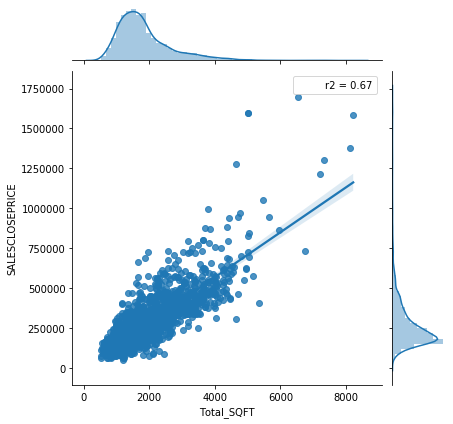

In [13]:
# Sample and create pandas dataframe
pandas_df = df.sample(False, 0.5, 0).toPandas()

# Linear model plots
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

sns.jointplot(x='Total_SQFT'
              , y='SALESCLOSEPRICE'
              , data=pandas_df
              , kind="reg"
              , stat_func=r2)
plt.show()

/home/danae/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


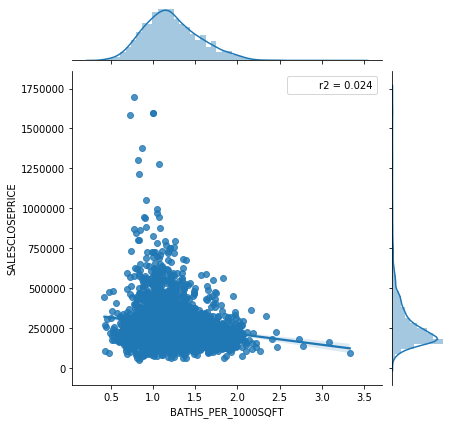

In [14]:
sns.jointplot(x='BATHS_PER_1000SQFT'
              , y='SALESCLOSEPRICE'
              , data=pandas_df
              , kind="reg"
              , stat_func=r2)
plt.show()

# 2. Time Features 
## 2.1 Components
Being able to work with time components for building features is important but you can also use them to explore and understand your data further. In this exercise, you'll be looking to see if there is a pattern to which day of the week a house lists on. Please keep in mind that `PySpark`'s week starts on Sunday, with a value of 1 and ends on Saturday, a value of 7.

In [15]:
# Import needed functions
#from pyspark.sql.functions import to_date, dayofweek

# Convert to date type
df = df.withColumn('LISTDATE', to_timestamp('LISTDATE', 'dd/MM/yyyy HH:mm'))

# Get the day of the week
df = df.withColumn('List_Day_of_Week', dayofweek('LISTDATE'))

#df.select('List_Day_of_Week').show(5)

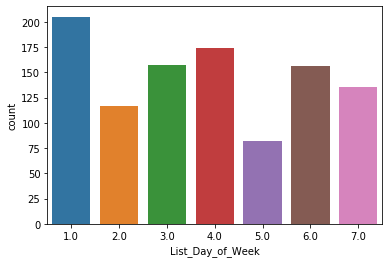

In [16]:
# Sample and convert to pandas dataframe
sample_df = df.sample(False, 0.5, 42).toPandas()

# Plot count plot of of day of week
sns.countplot(x="List_Day_of_Week", data=sample_df)
plt.show()

## 2.2 Joining On Time Components
Often times you will use date components to join in other sets of information. However, in this example, we need to use data that would have been available to those considering buying a house. This means we will need to use the previous year's reporting data for our analysis.

In [17]:
#from pyspark.sql.functions import year

# Initialize dataframes
#df = real_estate_df
#price_df = median_prices_df

# Create year column
df = df.withColumn('list_year', year('LISTDATE'))

# Adjust year to match
df = df.withColumn('report_year', (df['list_year'] - 1))

# Create join condition
#condition = [df['CITY'] == price_df['City'], df['report_year'] == price_df['Year']]

# Join the dataframes together
#df = df.join(price_df, on = condition, how = 'left')
# Inspect that new columns are available
#df[['MedianHomeValue']].show()

## 2.3 Date Math
In this example, we'll look at verifying the frequency of our data. The Mortgage dataset is supposed to have weekly data but let's make sure by lagging the report date and then taking the difference of the dates.

Recall that to create a lagged feature we will need to create a `window()`. The `window()` function allows you to return a value for each record based off some calculation against a group of records, in this case, the previous period's mortgage rate.

In [18]:
#from pyspark.sql.functions import lag, datediff, to_date
#from pyspark.sql.window import Window

# Cast data type
#mort_df = mort_df.withColumn('DATE', to_date('DATE'))

# Create window
#w = Window().orderBy(mort_df['DATE'])

# Create lag column
#mort_df = mort_df.withColumn('DATE-1', lag('DATE', count = 1).over(w))

# Calculate difference between date columns
#mort_df = mort_df.withColumn('Days_Between_Report', datediff('DATE', 'DATE-1'))

# Print results
#mort_df.select('Days_Between_Report').distinct().show()

# 3.  Extracting Text to New Features
## 3.1 Extracting Text to New Features
Garages are an important consideration for houses in Minnesota where most people own a car and the snow is annoying to clear off a car parked outside. The type of garage is also important, can you get to your car without braving the cold or not? Let's look at creating a feature `has_attached_garage` that captures whether the garage is attached to the house or not.

In [19]:
# Import needed functions
#from pyspark.sql.functions import when

# Create boolean conditions for string matches
has_attached_garage = df['GARAGEDESCRIPTION'].like('%Attached Garage%')
has_detached_garage = df['GARAGEDESCRIPTION'].like('%Detached Garage%')

# Conditional value assignment 
df = df.withColumn('has_attached_garage', (when(has_attached_garage, 1)
                                          .when(has_detached_garage, 0)
                                          .otherwise(None)))

# Inspect results
df.select('GARAGEDESCRIPTION', 'has_attached_garage').show(5, truncate=100)

+--------------------------------------------------------------+-------------------+
|                                             GARAGEDESCRIPTION|has_attached_garage|
+--------------------------------------------------------------+-------------------+
|                                               Attached Garage|                  1|
|       Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
|                                               Attached Garage|                  1|
|Attached Garage, Detached Garage, Tuckunder, Driveway - Gravel|                  1|
|       Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
+--------------------------------------------------------------+-------------------+
only showing top 5 rows



## 3.2 Splitting & Exploding
Being able to take a compound field like `GARAGEDESCRIPTION` and massaging it into something useful is an involved process. It's helpful to understand early what value you might gain out of expanding it. In this example, we will convert our string to a list-like array, explode it and then inspect the unique values.

In [20]:
# Import needed functions
#from pyspark.sql.functions import split, explode

# Convert string to list-like array
df = df.withColumn('garage_list', split(df['GARAGEDESCRIPTION'], ', '))

df.select('garage_list').show(5)

+--------------------+
|         garage_list|
+--------------------+
|   [Attached Garage]|
|[Attached Garage,...|
|   [Attached Garage]|
|[Attached Garage,...|
|[Attached Garage,...|
+--------------------+
only showing top 5 rows



In [21]:
# Explode the values into new records
ex_df = df.withColumn('ex_garage_list', explode(df['garage_list']))

# Inspect the values
ex_df[['ex_garage_list']].distinct().show(5, truncate=50)

+----------------------------+
|              ex_garage_list|
+----------------------------+
|             Attached Garage|
|      On-Street Parking Only|
|                        None|
| More Parking Onsite for Fee|
|          Garage Door Opener|
|   No Int Access to Dwelling|
|           Driveway - Gravel|
|       Valet Parking for Fee|
|              Uncovered/Open|
|               Heated Garage|
|          Underground Garage|
|                       Other|
|                  Unassigned|
|More Parking Offsite for Fee|
|    Driveway - Other Surface|
|       Contract Pkg Required|
|                     Carport|
|                     Secured|
|             Detached Garage|
|          Driveway - Asphalt|
|                  Units Vary|
|                    Assigned|
|                   Tuckunder|
|                     Covered|
|            Insulated Garage|
|         Driveway - Concrete|
|                      Tandem|
|           Driveway - Shared|
+----------------------------+



## 3.3 Pivot & Join
Being able to explode and pivot a compound field is great, but you are left with a dataframe of only those pivoted values. To really be valuable you'll need to rejoin it to the original dataset! After joining the datasets we will have a lot of NULL values for the newly created columns since we know the context of how they were created we can safely fill them in with zero as either the new has an attribute or it doesn't.

In [22]:
#from pyspark.sql.functions import coalesce, first

# Pivot 
#piv_df = ex_df.groupBy('NO').pivot('ex_garage_list').agg(coalesce(first('constant_val')))
#piv_df.show(5)

# Join the dataframes together and fill null
#joined_df = df.join(piv_df, on='NO', how='left')

# Columns to zero fill
#zfill_cols = piv_df.columns

# Zero fill the pivoted values
#zfilled_df = joined_df.fillna(0, subset=zfill_cols)

# 4. Binarizing, Bucketing & Encoding

## 4.1 Binarizing Day of Week

In a previous video, we saw that it was very unlikely for a home to list on the weekend. Let's create a new field that says if the house is listed for sale on a weekday or not. In this example there is a field called List_Day_of_Week that has Monday is labeled 1.0 and Sunday is 7.0. Let's convert this to a binary field with weekday being 0 and weekend being 1. We can use the pyspark feature transformer Binarizer to do this.


In [23]:
# Import transformer
from pyspark.ml.feature import Binarizer

df = df.withColumn('List_Day_of_Week', df['List_Day_of_Week'].cast('double'))

# Create the transformer
binarizer = Binarizer(threshold=5.0, inputCol='List_Day_of_Week', outputCol='Listed_On_Weekend')

# Apply the transformation to df
df = binarizer.transform(df)

In [24]:
# Verify transformation
df.select('List_Day_of_Week'
          , 'Listed_On_Weekend').sort(col('List_Day_of_Week').desc()).show(5)

+----------------+-----------------+
|List_Day_of_Week|Listed_On_Weekend|
+----------------+-----------------+
|             7.0|              1.0|
|             7.0|              1.0|
|             7.0|              1.0|
|             7.0|              1.0|
|             7.0|              1.0|
+----------------+-----------------+
only showing top 5 rows



## 4.2 Bucketing
If you are a homeowner its very important if a house has 1, 2, 3 or 4 bedrooms. But like bathrooms, once you hit a certain point you don't really care whether the house has 7 or 8. This example we'll look at how to figure out where are some good value points to bucket.

In [25]:
sample_df['BEDROOMS'].head()

0    3
1    3
2    3
3    3
4    3
Name: BEDROOMS, dtype: int64

In [26]:
# Plot distribution of sample_df
#sns.distplot(sample_df, axlabel='BEDROOMS')
#plt.show()

In [27]:
from pyspark.ml.feature import Bucketizer

# Create the bucket splits and bucketizer
splits = [0, 1, 2, 3, 4, 5, float('Inf')]
buck = Bucketizer(splits=splits, inputCol='BEDROOMS', outputCol='bedrooms')

# Apply the transformation to df: df_bucket
df_bucket = buck.transform(df)

# Display results
df_bucket[['BEDROOMS', 'bedrooms']].show(5)

+--------+--------+
|BEDROOMS|bedrooms|
+--------+--------+
|     3.0|     3.0|
|     4.0|     4.0|
|     2.0|     2.0|
|     2.0|     2.0|
|     3.0|     3.0|
+--------+--------+
only showing top 5 rows



## 4.3 One Hot Encoding

In the United States where you live determines which schools your kids can attend. Therefore it's understandable that many people care deeply about which school districts their future home will be in. While the school districts are numbered in `SCHOOLDISTRICTNUMBER` they are really categorical. Meaning that summing or averaging these values has no apparent meaning. Therefore in this example we will convert `SCHOOLDISTRICTNUMBER` from a categorial variable into a numeric vector to use in our machine learning model later.

In [28]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

# Map strings to numbers with string indexer
string_indexer = StringIndexer(inputCol='SCHOOLDISTRICTNUMBER', outputCol='School_Index')
indexed_df = string_indexer.fit(df).transform(df)

# Onehot encode indexed values
encoder = OneHotEncoder(inputCol='School_Index', outputCol='School_Vec')
encoded_df = encoder.transform(indexed_df)

# Inspect the transformation steps
encoded_df[['SCHOOLDISTRICTNUMBER', 'School_Index', 'School_Vec']].show(5, truncate=100)

+-----------------------------+------------+-------------+
|         SCHOOLDISTRICTNUMBER|School_Index|   School_Vec|
+-----------------------------+------------+-------------+
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|622 - North St Paul-Maplewood|         1.0|(7,[1],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|622 - North St Paul-Maplewood|         1.0|(7,[1],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0]

In [29]:
sc.stop() # close the spark session